# [**Débruitage d'image à l'aide de l'apprentissage de dictionnaire**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/2_5_decomposition/plot_image_denoising.ipynb)<br/>([*Image denoising using dictionary learning*](https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html))

Un exemple comparant l'effet de la reconstruction de fragments bruyants d'une image de visage de raton laveur à l'aide de l'apprentissage de dictionnaire en ligne et de différentes méthodes de transformation.

Le dictionnaire est adapté à la moitié gauche déformée de l'image, puis utilisé pour reconstruire la moitié droite. Notez que des performances encore meilleures pourraient être obtenues en adaptant le dictionnaire à une image non déformée (c'est-à-dire sans bruit), mais nous partons ici du principe qu'elle n'est pas disponible.

Une pratique courante pour évaluer les résultats du débruitage d'image consiste à regarder la différence entre la reconstruction et l'image d'origine. Si la reconstruction est parfaite, cela ressemblera à du bruit gaussien.

Il ressort des graphiques que les résultats de la [**poursuite orthogonale correspondante (OMP)** (1.1.9)](https://scikit-learn.org/stable/modules/linear_model.html#omp) avec deux coefficients non nuls sont un peu moins biaisés que lorsque l'on en garde un seul (les bords semblent moins prononcés). De plus, il est plus proche de la vérité fondamentale en norme de Frobenius.

Le résultat de la [**régression par angle minimal** (1.1.7)](https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression) est beaucoup plus fortement biaisé : la différence rappelle la valeur d'intensité locale de l'image originale.

Le seuillage n'est clairement pas utile pour le débruitage, mais il est là pour montrer qu'il peut produire une sortie suggestive avec une très grande vitesse et donc être utile pour d'autres tâches telles que la classification d'objets, où la performance n'est pas nécessairement liée à la visualisation.

# Générer une image déformée

In [1]:
import numpy as np


try:  # Scipy >= 1.10
    from scipy.datasets import face
except ImportError:
    from scipy.misc import face

raccoon_face = face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
raccoon_face = raccoon_face / 255.0

# downsample for higher speed
raccoon_face = (
    raccoon_face[::4, ::4]
    + raccoon_face[1::4, ::4]
    + raccoon_face[::4, 1::4]
    + raccoon_face[1::4, 1::4]
)
raccoon_face /= 4.0
height, width = raccoon_face.shape

# Distort the right half of the image
print("Distorting image...")
distorted = raccoon_face.copy()
distorted[:, width // 2 :] += 0.075 * np.random.randn(height, width // 2)

Distorting image...


# Afficher l'image déformée

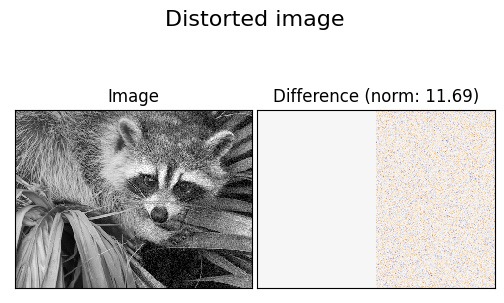

In [2]:
import matplotlib.pyplot as plt


def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title("Difference (norm: %.2f)" % np.sqrt(np.sum(difference**2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation="nearest"
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)


show_with_diff(distorted, raccoon_face, "Distorted image")

# Extraire des fragments de référence

In [3]:
from time import time

from sklearn.feature_extraction.image import extract_patches_2d

# Extract all reference patches from the left half of the image
print("Extracting reference patches...")
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, : width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted in %.2fs." % (time() - t0))

Extracting reference patches...
22692 patches extracted in 0.02s.


# Apprendre le dictionnaire à partir des fragments de référence

Learning the dictionary...
1.0 iterations / 106 steps in 19.81.


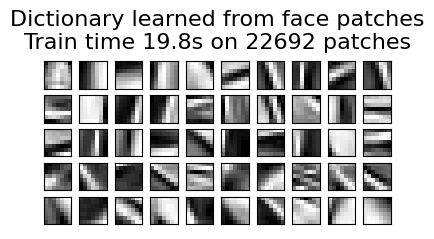

In [4]:
from sklearn.decomposition import MiniBatchDictionaryLearning

print("Learning the dictionary...")
t0 = time()
dico = MiniBatchDictionaryLearning(
    # increase to 300 for higher quality results at the cost of slower
    # training times.
    n_components=50,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
)
V = dico.fit(data).components_
dt = time() - t0
print(f"{dico.n_iter_} iterations / {dico.n_steps_} steps in {dt:.2f}.")

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

# Extraire des fragments bruyants et les reconstruire en utilisant le dictionnaire

Extracting noisy patches... 
done in 0.02s.
Orthogonal Matching Pursuit
1 atom...
done in 1.20s.
Orthogonal Matching Pursuit
2 atoms...
done in 2.91s.
Least-angle regression
4 atoms...
done in 13.33s.
Thresholding
 alpha=0.1...
done in 0.16s.


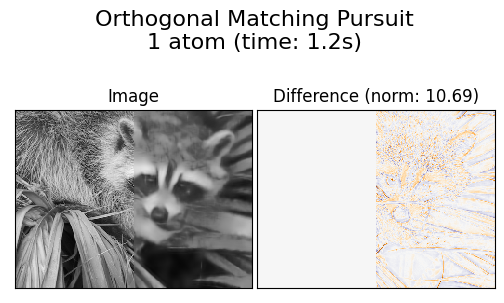

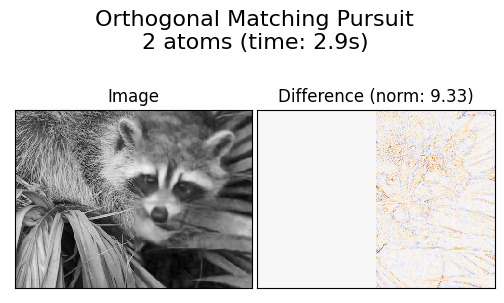

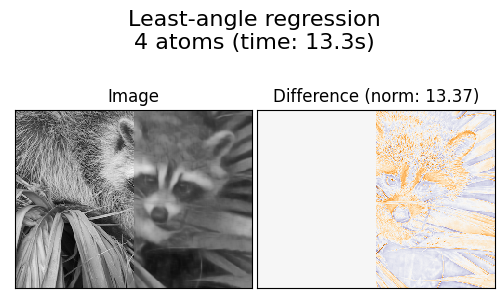

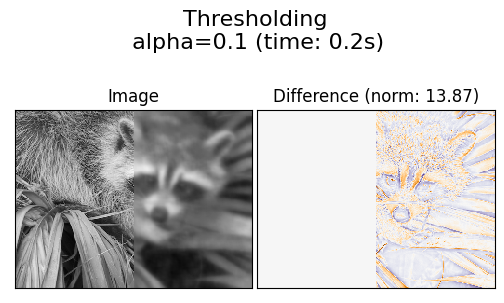

In [5]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

print("Extracting noisy patches... ")
t0 = time()
data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print("done in %.2fs." % (time() - t0))

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Least-angle regression\n4 atoms", "lars", {"transform_n_nonzero_coefs": 4}),
    ("Thresholding\n alpha=0.1", "threshold", {"transform_alpha": 0.1}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = raccoon_face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == "threshold":
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2 :] = reconstruct_from_patches_2d(
        patches, (height, width // 2)
    )
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], raccoon_face, title + " (time: %.1fs)" % dt)

plt.show()